# Task 4: Network Anomaly Detection using a Deep Autoencoder

## Project Overview

**Objective:**
The primary goal of this project is to develop and evaluate a deep autoencoder model for detecting anomalies in network traffic. The model will be trained to distinguish between normal network connections and various types of malicious attacks, such as Denial-of-Service (DoS), port scanning, and unauthorized access attempts.

**Dataset:**
The project utilizes the **KDD Cup 1999 dataset**, which was created by MIT Lincoln Labs for intrusion detection system evaluations. We will be working with the `kddcup.data_10_percent.gz` subset, which contains a large number of network connection records. Each record is described by 41 features and is labeled as either `normal.` or a specific type of attack.

**Methodology:**
The core approach is to build an autoencoder, a type of neural network trained to reconstruct its input data. The key steps of the methodology are:
1.  **Data Loading and Preprocessing:** Load the dataset, assign correct column names, and perform necessary preprocessing, including scaling numerical features and encoding categorical ones.
2.  **Model Architecture:** Design a deep autoencoder with multiple dense layers for both the encoder and the decoder.
3.  **Training Strategy:** Crucially, the autoencoder will be trained **exclusively on data corresponding to 'normal' network traffic**. The underlying hypothesis is that the model will learn to reconstruct normal data with a low error, but will struggle to reconstruct anomalous data (attacks), resulting in a high reconstruction error.
4.  **Evaluation:** The reconstruction error will serve as an anomaly score. By setting an appropriate threshold on this error, we can classify connections as either normal or anomalous. The model's performance will be evaluated on a test set containing both normal and anomalous data using metrics such as the confusion matrix, Receiver Operating Characteristic (ROC) curve, and the Area Under the Curve (AUC).

**Tools and Libraries:**
*   **Python 3.x**
*   **Pandas & NumPy** for data manipulation.
*   **Scikit-learn** for data preprocessing (scaling, splitting).
*   **TensorFlow/Keras** for building and training the deep autoencoder model.
*   **Matplotlib & Seaborn** for data visualization.

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Data Loading and Analysis

In [2]:
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# List to store column names
column_names = []

# Load column names from the kddcup.names file
with open('kddcup.names', 'r') as f:
    for line in f:
        # Skip lines that do not contain column descriptions
        if ':' in line:
            # Split the line by ':' and take the first part as the column name
            name = line.split(':')[0]
            column_names.append(name)

# Add the target column name at the end, which is not described among the features
column_names.append('outcome')

print(f"Number of loaded column names: {len(column_names)}")
print("List of column names:")
print(column_names)

# Path to the data file
file_path = 'kddcup.data_10_percent.gz'

# Load data into a pandas DataFrame
df = pd.read_csv(file_path, header=None, names=column_names, compression='gzip')

print("Data loaded. DataFrame dimensions:")
print(df.shape)

# Check unique values and their counts in the 'outcome' column
outcome_counts = df['outcome'].value_counts()

print(f"Number of unique values in the 'outcome' column: {len(outcome_counts)}")
print("\nCounts of each transmission type:")
print(outcome_counts)

Number of loaded column names: 42
List of column names:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']
Data loaded. DataFrame dimensions:
(494021, 42)
Number of unique values in the 'outcome' column: 23

Counts of each transmission type:
outcome
smurf.              280790
neptune.            107201
normal.

### 2. Preliminary Exploratory Data Analysis (EDA)

In [3]:
# Generate statistics for numerical columns
display(df.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
duration,494021.0,47.979302,707.746472,0.0,0.00,0.0,0.00,58329.0
src_bytes,494021.0,3025.610296,988218.101045,0.0,45.00,520.0,1032.00,693375640.0
dst_bytes,494021.0,868.532425,33040.001252,0.0,0.00,0.0,0.00,5155468.0
land,494021.0,0.000045,0.006673,0.0,0.00,0.0,0.00,1.0
wrong_fragment,494021.0,0.006433,0.134805,0.0,0.00,0.0,0.00,3.0
urgent,494021.0,0.000014,0.005510,0.0,0.00,0.0,0.00,3.0
hot,494021.0,0.034519,0.782103,0.0,0.00,0.0,0.00,30.0
num_failed_logins,494021.0,0.000152,0.015520,0.0,0.00,0.0,0.00,5.0
logged_in,494021.0,0.148247,0.355345,0.0,0.00,0.0,0.00,1.0
num_compromised,494021.0,0.010212,1.798326,0.0,0.00,0.0,0.00,884.0


#### Numerical Variables (38 Features)
These variables represent measurable quantities. They will require **scaling** (e.g., normalization or standardization) to ensure stable model training.

1.  **Basic Connection Features**
    * **`duration`**: Connection duration in seconds.
    * **`src_bytes`**: Number of bytes sent from source to destination.
    * **`dst_bytes`**: Number of bytes sent from destination to source.
    * **`land`**: 1 if connection is from/to the same host/port; 0 otherwise.
    * **`wrong_fragment`**: Number of wrong fragments in IP packets.
    * **`urgent`**: Number of urgent packets (with URG flag).

2.  **Content-Related Features (e.g., login, access)**
    * **`hot`**: Number of "hot" indicators (e.g., attempts to access protected system resources, root logins).
    * **`num_failed_logins`**: Number of failed login attempts.
    * **`logged_in`**: 1 if successfully logged in; 0 otherwise.
    * **`num_compromised`**: Number of "compromised" conditions (e.g., file changes).
    * **`root_shell`**: 1 if root shell access was obtained; 0 otherwise.
    * **`su_attempted`**: 1 if "su" command (switch user to root) was attempted; 0 otherwise.
    * **`num_root`**: Number of root operations.
    * **`num_file_creations`**: Number of file creation operations.
    * **`num_shells`**: Number of shell prompts.
    * **`num_access_files`**: Number of access control file operations.
    * **`num_outbound_cmds`**: Number of outbound commands (always 0 in this dataset).
    * **`is_host_login`**: 1 if login is to a special host (e.g., FTP server); 0 otherwise.
    * **`is_guest_login`**: 1 if logged in as "guest"; 0 otherwise.

3.  **Time-Based Features (traffic analysis in a 2-second window)**
    * **`count`**: Number of connections to the same host in the last 2 seconds.
    * **`srv_count`**: Number of connections to the same service in the last 2 seconds.
    * **`serror_rate`**: Percentage of connections with "SYN" errors (S0) in the last 2 seconds.
    * **`srv_serror_rate`**: Percentage of connections with "SYN" errors (S0) to the same service in the last 2 seconds.
    * **`rerror_rate`**: Percentage of connections with "REJ" errors in the last 2 seconds.
    * **`srv_rerror_rate`**: Percentage of connections with "REJ" errors to the same service in the last 2 seconds.
    * **`same_srv_rate`**: Percentage of connections to the same service.
    * **`diff_srv_rate`**: Percentage of connections to different services.
    * **`srv_diff_host_rate`**: Percentage of connections to different hosts within the same service.

4.  **Host-Based Features (traffic analysis in a 100-connection window)**
    * **`dst_host_count`**: Number of connections to the same destination host in the last 100 connections.
    * **`dst_host_srv_count`**: Number of connections to the same service on the same destination host.
    * **`dst_host_same_srv_rate`**: Percentage of connections to the same service on the destination host.
    * **`dst_host_diff_srv_rate`**: Percentage of connections to different services on the destination host.
    * **`dst_host_same_src_port_rate`**: Percentage of connections from the same source port on the destination host.
    * **`dst_host_srv_diff_host_rate`**: Percentage of connections to different hosts for the same service on the destination host.
    * **`dst_host_serror_rate`**: Percentage of connections with "SYN" errors on the destination host.
    * **`dst_host_srv_serror_rate`**: Percentage of connections with "SYN" errors for the same service on the destination host.
    * **`dst_host_rerror_rate`**: Percentage of connections with "REJ" errors on the destination host.
    * **`dst_host_srv_rerror_rate`**: Percentage of connections with "REJ" errors for the same service on the destination host.

In [4]:
# Generate statistics for categorical columns
display(df.describe(include=['object']))

,protocol_type,service,flag,outcome
count,494021,494021,494021,494021
unique,3,66,11,23
top,icmp,ecr_i,SF,smurf.
freq,283602,281400,378440,280790


#### Categorical Variables (3 Features)
These are nominal variables that describe types or categories. They will require **encoding** (e.g., one-hot encoding) before being fed into a neural network.

* `protocol_type`: Type of protocol used in the connection.
    * *Example values:* `tcp`, `udp`, `icmp`.
* `service`: Network service on the destination port.
    * *Example values:* `http`, `smtp`, `ftp`, `ecr_i` (ICMP service).
* `flag`: Connection completion status.
    * *Example values:* `SF` (normal completion), `S0` (connection attempt without response), `REJ` (connection rejected).


Distribution of the 'outcome' variable:


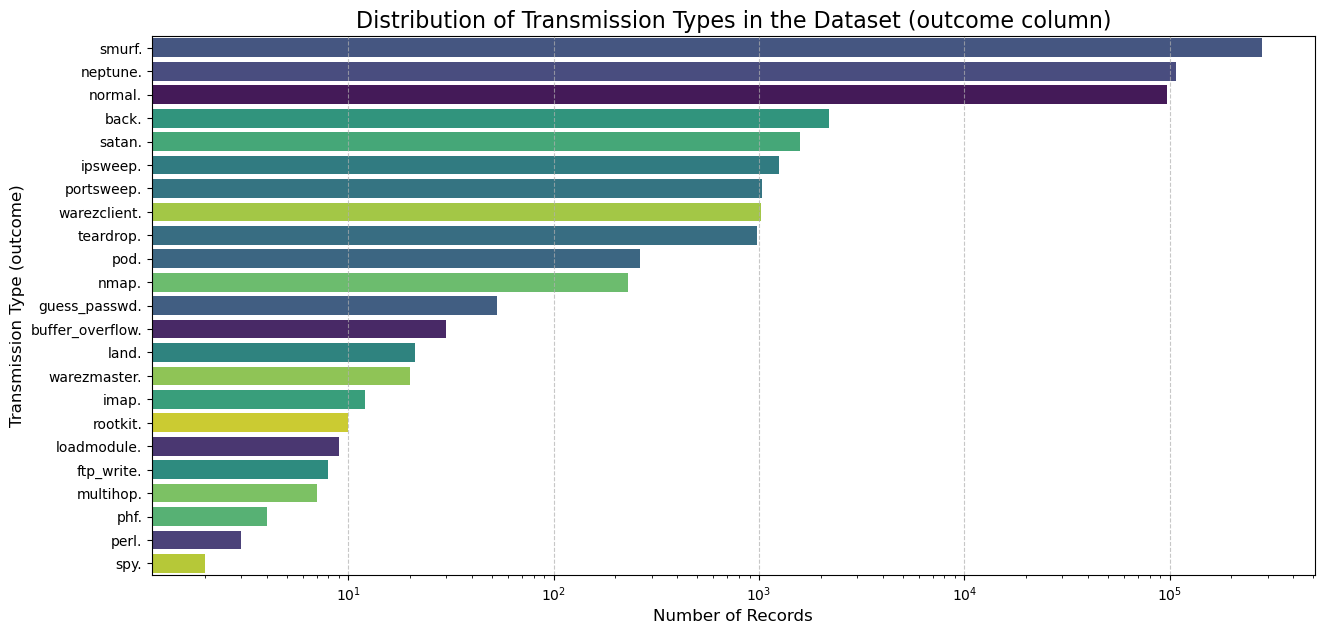

In [5]:
# Distribution of the 'outcome' variable
print("\nDistribution of the 'outcome' variable:")
plt.figure(figsize=(15, 7))
sns.countplot(y='outcome', data=df, order=df['outcome'].value_counts().index, palette='viridis', hue='outcome')
plt.title('Distribution of Transmission Types in the Dataset (outcome column)', fontsize=16)
plt.xlabel('Number of Records', fontsize=12)
plt.ylabel('Transmission Type (outcome)', fontsize=12)
plt.xscale('log') # Use a logarithmic scale to make smaller categories visible
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Comment on the Result

* The absolute dominance of **smurf.** and **neptune.** attacks. Their number is so large that without a logarithmic scale, other categories would be practically invisible.
* **Normal traffic (`normal.`)** is the third most numerous category.
* Many attack types (e.g., **perl**, **phf**, **spy**) occur very rarely (fewer than 10 times in the entire dataset). This is important information, as the model may have difficulty generalizing based on such small numbers of examples.

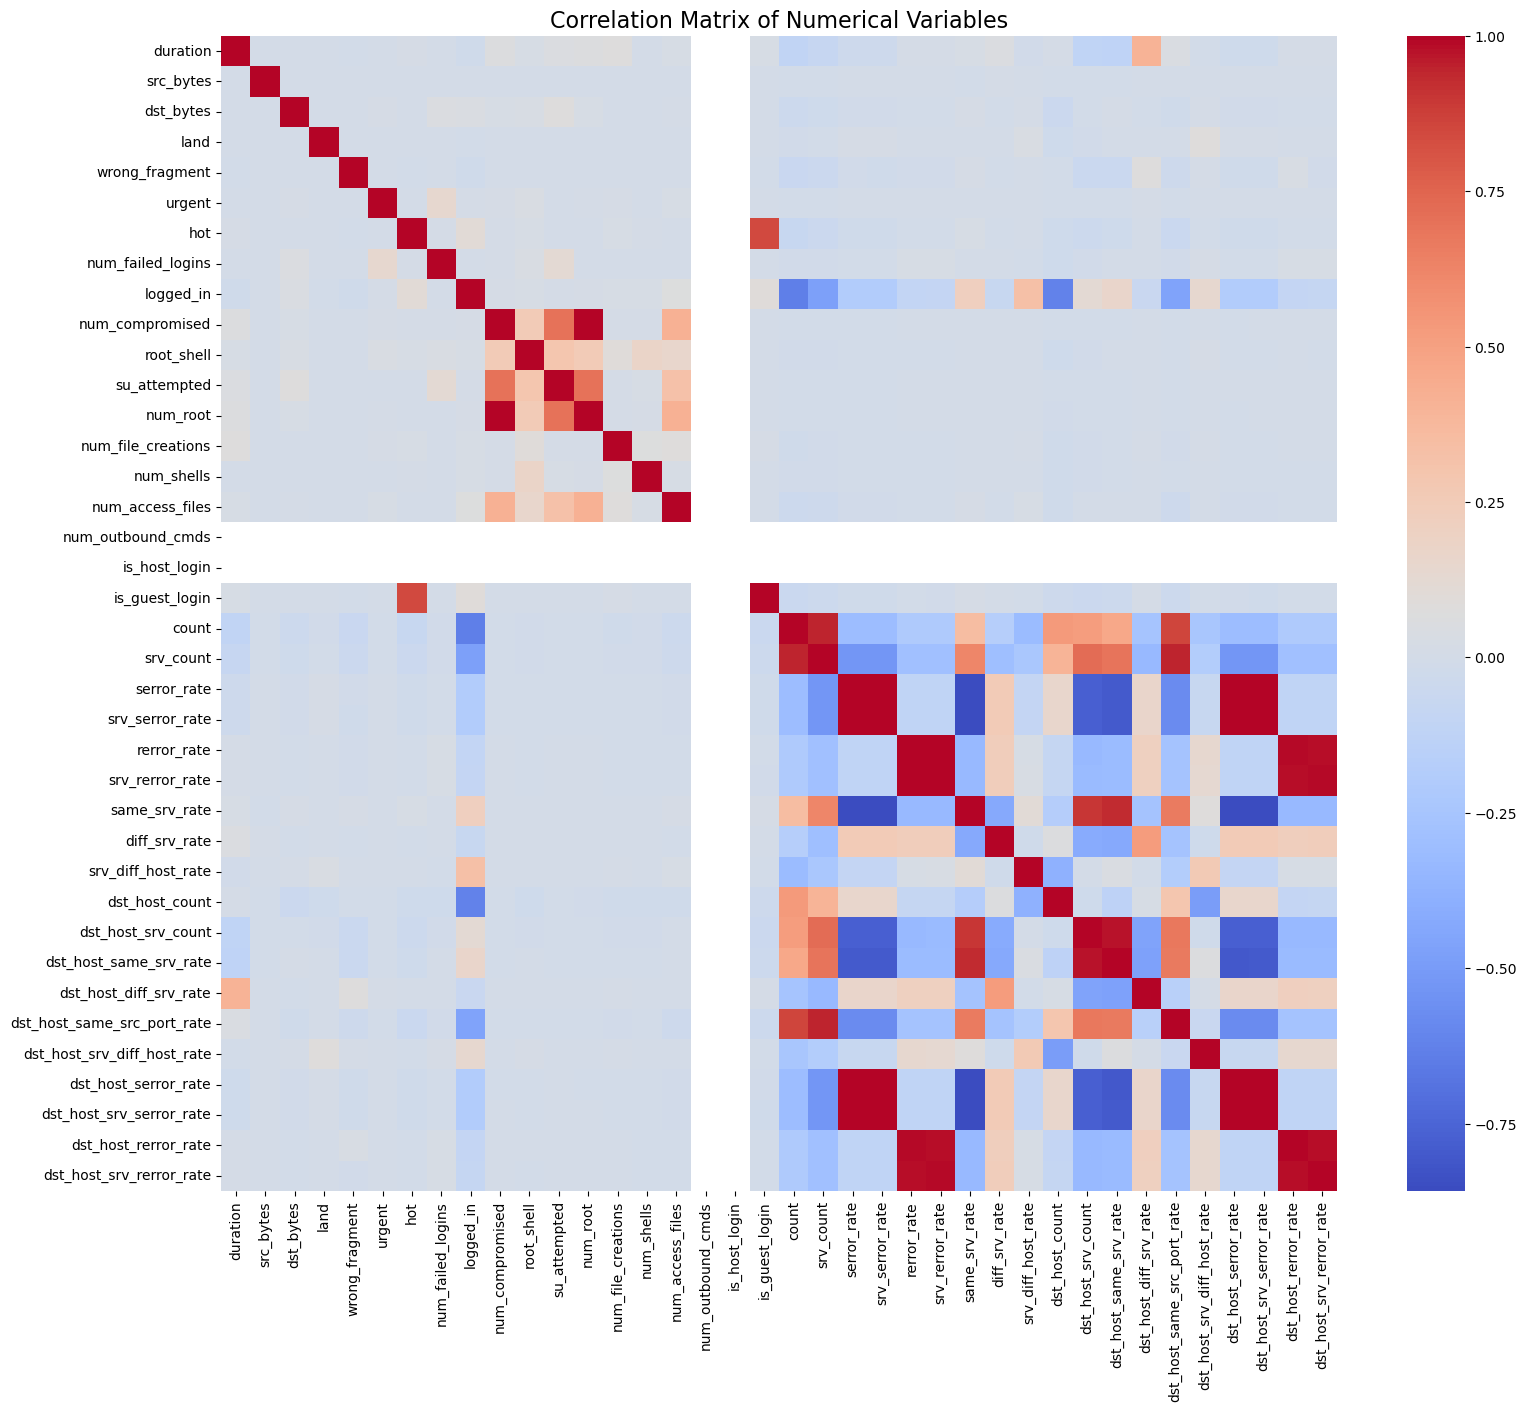

In [6]:
# Check for strong dependencies between numerical variables
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # annot=False because there are too many fields
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.show()

### 3. Investigating Missing Data and Outliers

In [7]:
# Check the number of missing values in each column
missing_values = df.isnull().sum()

# Display columns that have any missing values (if any)
print("Number of missing values in each column:")
print(missing_values[missing_values > 0])

# Display the total number of missing values in the entire dataset
total_missing = missing_values.sum()
print(f"\nTotal number of missing values in the dataset: {total_missing}")

Number of missing values in each column:
Series([], dtype: int64)

Total number of missing values in the dataset: 0
